In [1]:
import json
from pprint import pprint

import jsonlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm, trange
from datasets import load_dataset

code_to_lang = {
    "en": "English",
    "de": "German",
    "es": "Spanish",
    "fr": "French",
    "ja": "Japanese",
    "zh": "Chinese",
}


In [3]:
full_train_dataset = load_dataset("amazon_reviews_multi", split="train").with_format(
    "torch"
)
full_valid_dataset = load_dataset("amazon_reviews_multi", split="validation").with_format(
    "torch"
)
full_test_dataset = load_dataset("amazon_reviews_multi", split="test").with_format(
    "torch"
)


No config specified, defaulting to: amazon_reviews_multi/all_languages
Found cached dataset amazon_reviews_multi (/home/matias/.cache/huggingface/datasets/amazon_reviews_multi/all_languages/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)
No config specified, defaulting to: amazon_reviews_multi/all_languages
Found cached dataset amazon_reviews_multi (/home/matias/.cache/huggingface/datasets/amazon_reviews_multi/all_languages/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)
No config specified, defaulting to: amazon_reviews_multi/all_languages
Found cached dataset amazon_reviews_multi (/home/matias/.cache/huggingface/datasets/amazon_reviews_multi/all_languages/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


In [110]:
train_dataset_tokenized = (
    load_dataset(
        "json", data_files={"train": "ARC/train_dataset_bert_tokenized.jsonl"}, split="train"
    )
)
valid_dataset_tokenized = (
    load_dataset(
        "json", data_files={"train": "ARC/valid_dataset_bert_tokenized.jsonl"}, split="train"
    )
)
test_dataset_tokenized = (
    load_dataset(
        "json", data_files={"train": "ARC/test_dataset_bert_tokenized.jsonl"}, split="train"
    )
)


Using custom data configuration default-a3faa38d34f6af55


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /home/matias/.cache/huggingface/datasets/json/default-a3faa38d34f6af55/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab. Subsequent calls will reuse this data.


Using custom data configuration default-265673c1176f9c06


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /home/matias/.cache/huggingface/datasets/json/default-265673c1176f9c06/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab. Subsequent calls will reuse this data.


Using custom data configuration default-5ed1e2abb728c315


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /home/matias/.cache/huggingface/datasets/json/default-5ed1e2abb728c315/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab. Subsequent calls will reuse this data.


In [20]:
full_train_id = np.array(full_train_dataset["review_id"])
small_train_id = np.array(train_dataset_tokenized["review_id"])
idx_train = np.isin(full_train_id, small_train_id)
idx_train = np.arange(len(full_train_id))[idx_train]
train_dataset = full_train_dataset.select(idx_train)

full_valid_id = np.array(full_valid_dataset["review_id"])
small_valid_id = np.array(valid_dataset_tokenized["review_id"])
idx_valid = np.isin(full_valid_id, small_valid_id)
idx_valid = np.arange(len(full_valid_id))[idx_valid]
valid_dataset = full_valid_dataset.select(idx_valid)

In [22]:
def utf8len(s):
    return len(s.encode("utf-8"))


In [92]:
def extract_metrics(dataset, language="English"):
    length_shortest_sample = np.inf
    samples_with_shortest_sample = []

    length_longest_sample = 0
    samples_with_longest_sample = []

    metrics = []
    for sample in tqdm(dataset):

        modified_language = code_to_lang[sample["language"]]
        modified_product_category = sample["product_category"].replace("_", " ")
        modified_product_category = modified_product_category[0].upper() + modified_product_category[1:]

        if (
            len(sample["review_body"]) == length_shortest_sample
            and modified_language == language
        ):
            samples_with_shortest_sample += [sample]
        if (
            len(sample["review_body"]) < length_shortest_sample
            and modified_language == language
        ):
            length_shortest_sample = len(sample["review_body"])
            samples_with_shortest_sample = [sample]

        if (
            len(sample["review_body"]) == length_longest_sample
            and modified_language == language
        ):
            samples_with_longest_sample += [sample]
        if (
            len(sample["review_body"]) > length_longest_sample
            and modified_language == language
        ):
            length_longest_sample = len(sample["review_body"])
            samples_with_longest_sample = [sample]

        metric = {
            "document_length": len(sample["review_body"]),
            "document_length_byte": utf8len(sample["review_body"]),
            "unique_caracters_document": len(np.unique(list(sample["review_body"]))),
            "product_category": modified_product_category,
            "title_length": len(sample["review_title"]),
            "title_length_byte": utf8len(sample["review_title"]),
            "unique_caracters_title": len(np.unique(list(sample["review_title"]))),
            "language": modified_language,
            "stars": sample["stars"].item()
        }
        metrics.append(metric)
    metrics = pd.DataFrame.from_records(metrics).sort_values("language", ascending=False)
    return metrics, samples_with_shortest_sample, samples_with_longest_sample

(
    train_metrics,
    train_samples_with_shortest_sample,
    train_samples_with_longest_sample,
) = extract_metrics(train_dataset)
(
    valid_metrics,
    valid_samples_with_shortest_sample,
    valid_samples_with_longest_sample,
) = extract_metrics(valid_dataset)



100%|██████████| 1000/1000 [00:00<00:00, 2218.24it/s]


In [94]:
train_samples_with_longest_sample

[{'review_id': 'en_0902148',
  'product_id': 'product_en_0595978',
  'reviewer_id': 'reviewer_en_0983661',
  'stars': tensor(3),
  'review_body': 'I am 5\'9, 162 pounds, and typically wear size 10 tall/long in pants. After reading all the reviews that these pants run a little large - I decided to stick with my size as a 10 because I wanted something that was a little more loose fitting and forgiving. I am glad I didn\'t order a size smaller because both pair I received did NOT run small. As a matter of fact - if I were to order again, I would size UP 1 size in order to have a little more room. The size 10 fit, but are a little tight everywhere except the waist. And as far as the length goes - I ordered the regular instead of the long, again because of reviews. They are BARELY long enough. The fit is more of a flare leg, not a straight leg. This wouldn\'t be that big of a deal if they were longer, but coming at mid-ankle and being flared just looks all kinds of wrong. I may just have to

Smallest and longest question samples in the dataset for English and Arabic

### English samples:

- **Title**: Who are all these people leaving 5 star reviews?
    
    **Body**: I am 5'9, 162 pounds, and typically wear size 10 tall/long in pants. After reading all the reviews that these pants run a little large - I decided to stick with my size as a 10 because I wanted something that was a little more loose fitting and forgiving. I am glad I didn't order a size smaller because both pair I received did NOT run small. As a matter of fact - if I were to order again, I would size UP 1 size in order to have a little more room. The size 10 fit, but are a little tight everywhere except the waist. And as far as the length goes - I ordered the regular instead of the long, again because of reviews. They are BARELY long enough. The fit is more of a flare leg, not a straight leg. This wouldn't be that big of a deal if they were longer, but coming at mid-ankle and being flared just looks all kinds of wrong. I may just have to send these back and order the long size and have them altered. I wish there was a choice in between a 32" inseam and a 36" inseam. The fit is mid to low rise and comes about 2" below my belly button. The zip pocket in the front fits my Galaxy 7 phone, but since the legs are tight I wouldn't put my phone here as it would be uncomfortable, look bulgy, and would somewhat restrict movement. I agree with others that the drawstring is fairly useless, and I also agree that it might be a good idea to double stitch the buttons once you get the pants. These are made in China and the manufacturing quality is probably not in line with the price point of these pants. They did however include an extra button stitched to the inside tag of the pants in case you lose one. At this point - 3 stars is the best I could offer these pants. I will return the ones I have for a 12 Long and update my review at that time. Hope this helps some of you that are taller than 5'7 but shorter than 6 foot!
    
- **Title**: One Star
    
    **Body**: I never received it.

- **Title**: Coucou
    
    **Body**: Usuel et sport Déçu
    

In [69]:
train_metrics_per_language = train_metrics.groupby("language").agg(
    {
        "document_length": "mean",
        "document_length_byte": "mean",
        "unique_caracters_document": "mean",
        "title_length": "mean",
        "title_length_byte": "mean",
        "unique_caracters_title": "mean",
        # "product_category": "mean",
    }
)
train_metrics_per_language["count"] = train_metrics.groupby("language").count()[
    "document_length"
]

valid_metrics_per_language = valid_metrics.groupby("language").agg(
    {
        "document_length": "mean",
        "document_length_byte": "mean",
        "unique_caracters_document": "mean",
        "title_length": "mean",
        "title_length_byte": "mean",
        "unique_caracters_title": "mean",
        # "product_category": "mean",
    }
)
valid_metrics_per_language["count"] = valid_metrics.groupby("language").count()[
    "document_length"
]


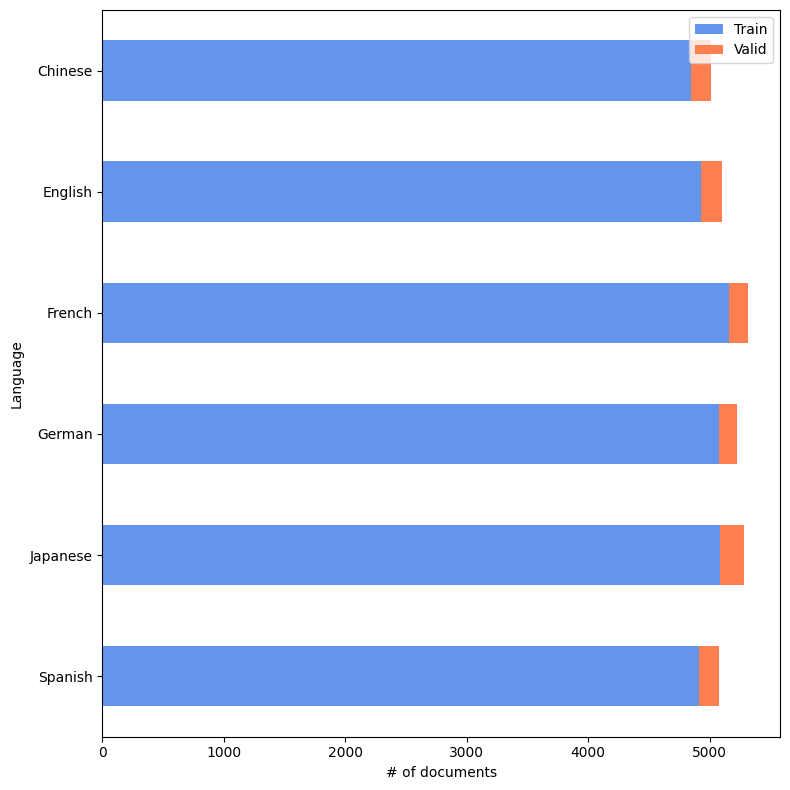

In [70]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

document_number_metric = pd.DataFrame(
    data=[train_metrics_per_language["count"], valid_metrics_per_language["count"]],
    index=["Train", "Valid"],
).T.sort_values("language", ascending=False)

document_number_metric.plot(
    kind="barh",
    stacked=True,
    color=[
        "cornflowerblue",
        "coral",
        "lightgreen"
    ],
    ax=axs,
)
axs.legend(loc="upper right")
axs.set_ylabel("Language")
axs.set_xlabel("# of documents")
plt.tight_layout()
plt.savefig("ARC/number_documents.jpg", dpi=300)


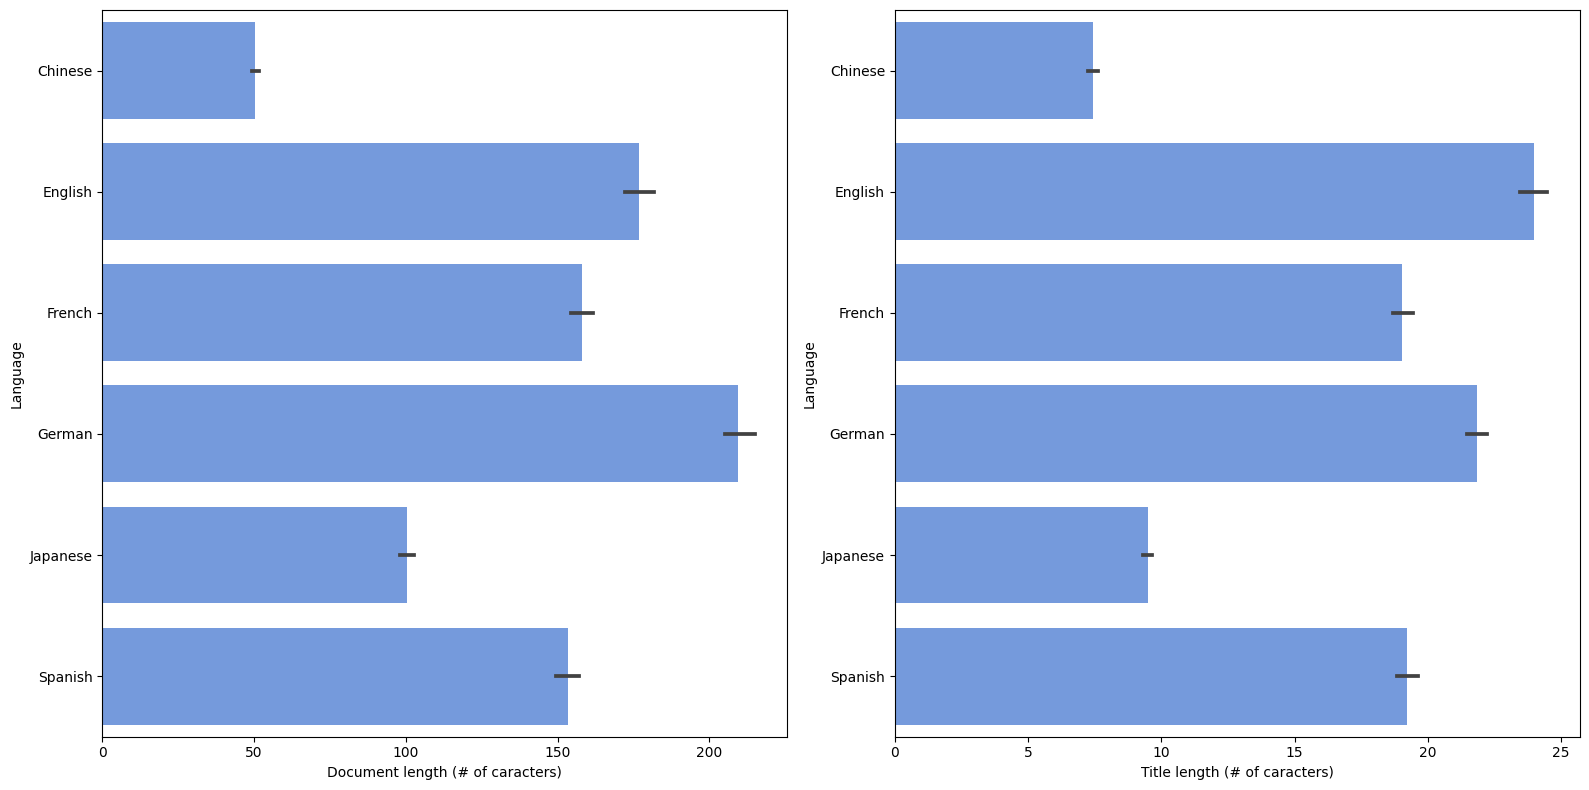

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

ordered_languages = train_metrics_per_language.index.sort_values(ascending=True)

sns.barplot(
    train_metrics,
    x="document_length",
    y="language",
    ax=axs[0],
    color="cornflowerblue",
    order=ordered_languages,
)
axs[0].set_xlabel("Document length (# of caracters)")
axs[0].set_ylabel("Language")
sns.barplot(
    train_metrics,
    x="title_length",
    y="language",
    ax=axs[1],
    color="cornflowerblue",
    order=ordered_languages,
)
axs[1].set_xlabel("Title length (# of caracters)")
axs[1].set_ylabel("Language")
plt.tight_layout()
plt.savefig("ARC/train_doc_q_length.jpg", dpi=300)


In [73]:
train_metrics_per_product = train_metrics.groupby("product_category").agg(
    {
        "document_length": "mean",
        "document_length_byte": "mean",
        "unique_caracters_document": "mean",
        "title_length": "mean",
        "title_length_byte": "mean",
        "unique_caracters_title": "mean",
        # "product_category": "mean",
    }
)
train_metrics_per_product["count"] = train_metrics.groupby("product_category").count()[
    "document_length"
]

valid_metrics_per_product = valid_metrics.groupby("product_category").agg(
    {
        "document_length": "mean",
        "document_length_byte": "mean",
        "unique_caracters_document": "mean",
        "title_length": "mean",
        "title_length_byte": "mean",
        "unique_caracters_title": "mean",
        # "product_category": "mean",
    }
)
valid_metrics_per_product["count"] = valid_metrics.groupby("product_category").count()[
    "document_length"
]

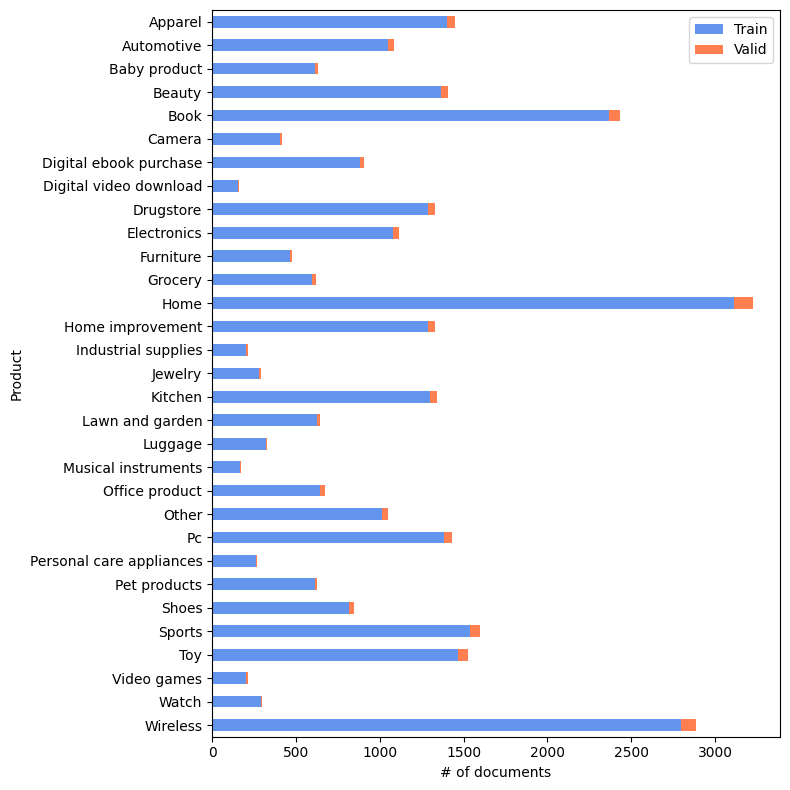

In [74]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

document_number_metric = pd.DataFrame(
    data=[train_metrics_per_product["count"], valid_metrics_per_product["count"]],
    index=["Train", "Valid"],
).T.sort_values("product_category", ascending=False)

a = document_number_metric.index
new_index = []
for i in document_number_metric.index:
    c = i.replace("_", " ")
    new_index.append(c[0].upper() + c[1:])
document_number_metric.index = new_index

document_number_metric.plot(
    kind="barh",
    stacked=True,
    color=[
        "cornflowerblue",
        "coral",
        "lightgreen"
    ],
    ax=axs,
)

axs.set_ylabel("Product")
axs.set_xlabel("# of documents")
plt.tight_layout()
plt.savefig("ARC/number_product.jpg", dpi=300)


In [75]:
train_metrics_per_star = train_metrics.groupby("stars").agg(
    {
        "document_length": "mean",
        "document_length_byte": "mean",
        "unique_caracters_document": "mean",
        "title_length": "mean",
        "title_length_byte": "mean",
        "unique_caracters_title": "mean",
        # "product_category": "mean",
    }
)
train_metrics_per_star["count"] = train_metrics.groupby("stars").count()[
    "document_length"
]

valid_metrics_per_star = valid_metrics.groupby("stars").agg(
    {
        "document_length": "mean",
        "document_length_byte": "mean",
        "unique_caracters_document": "mean",
        "title_length": "mean",
        "title_length_byte": "mean",
        "unique_caracters_title": "mean",
        # "product_category": "mean",
    }
)
valid_metrics_per_star["count"] = valid_metrics.groupby("stars").count()[
    "document_length"
]

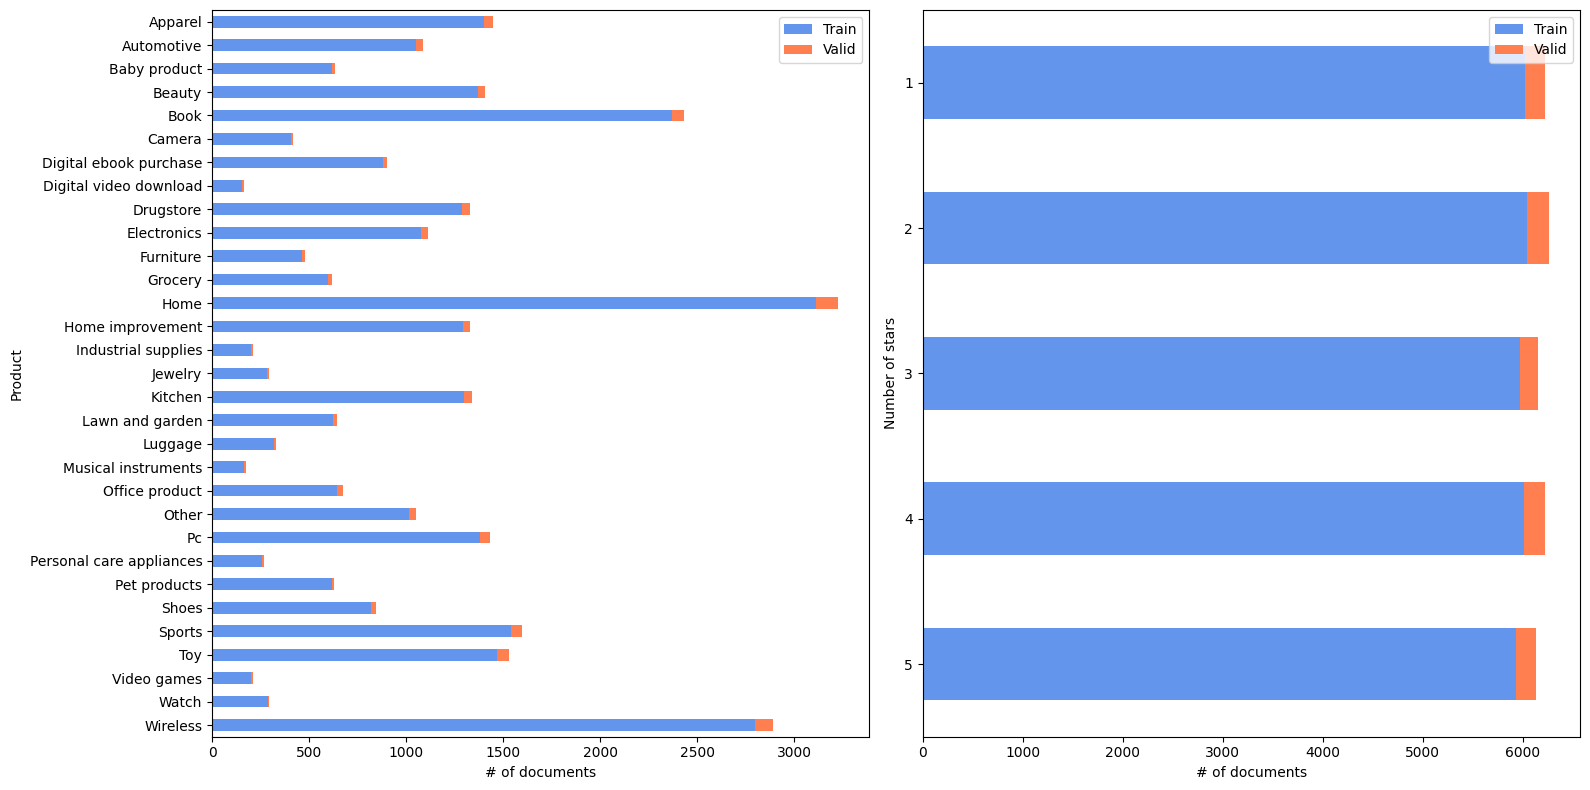

In [88]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

document_number_metric = pd.DataFrame(
    data=[train_metrics_per_product["count"], valid_metrics_per_product["count"]],
    index=["Train", "Valid"],
).T.sort_values("product_category", ascending=False)

a = document_number_metric.index
new_index = []
for i in document_number_metric.index:
    c = i.replace("_", " ")
    new_index.append(c[0].upper() + c[1:])
document_number_metric.index = new_index

document_number_metric.plot(
    kind="barh",
    stacked=True,
    color=[
        "cornflowerblue",
        "coral",
        "lightgreen"
    ],
    ax=axs[0],
)

axs[0].set_ylabel("Product")
axs[0].set_xlabel("# of documents")


document_number_metric = pd.DataFrame(
    data=[train_metrics_per_star["count"], valid_metrics_per_star["count"]],
    index=["Train", "Valid"],
).T.sort_values("stars", ascending=False)

document_number_metric.plot(
    kind="barh",
    stacked=True,
    color=[
        "cornflowerblue",
        "coral",
        "lightgreen"
    ],
    ax=axs[1],
)
axs[1].legend(loc="upper right")
axs[1].set_ylabel("Number of stars")
axs[1].set_xlabel("# of documents")
plt.tight_layout()
plt.savefig("ARC/number_product_star.jpg", dpi=300)


In [96]:
predictions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

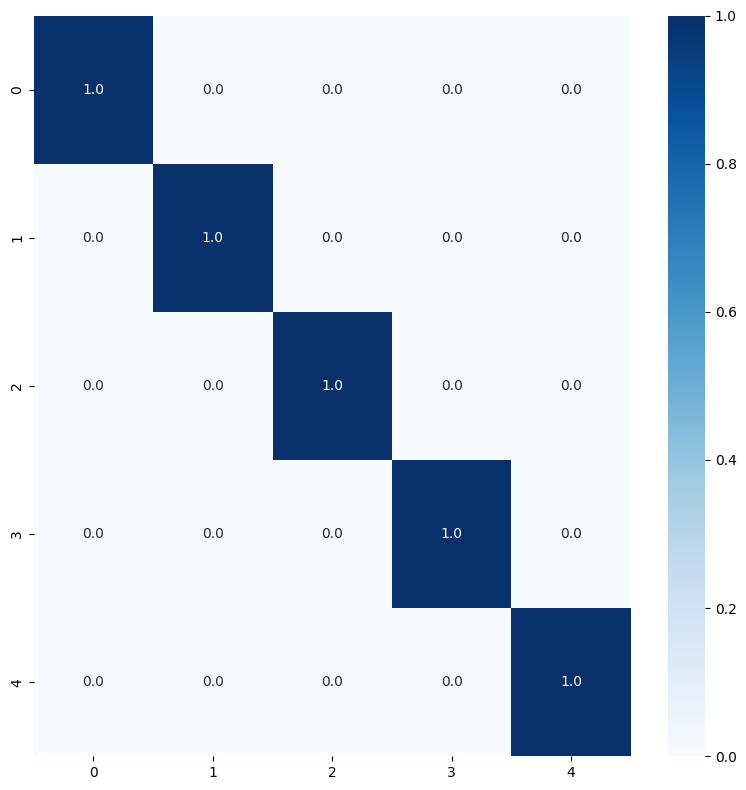

In [111]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

labels = test_dataset_tokenized["label"]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
cm = confusion_matrix(
    labels,
    predictions,
    normalize="true",
)
sns.heatmap(
    cm,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    ax=ax,
)
plt.tight_layout()

In [109]:
test_dataset_tokenized["review"]

KeyError: "Column review not in the dataset. Current columns in the dataset: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category', 'input_ids', 'token_type_ids', 'attention_mask', 'label']"